In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

In [3]:
from plaid.compression.hourglass_vq import HourglassVQLightningModule
from plaid.esmfold import esmfold_v1
from pathlib import Path

ckpt_dir = Path("/homefs/home/lux70/storage/plaid/checkpoints/hourglass_vq/")
compression_id = "8ebs7j9h"
ckpt_fpath = ckpt_dir / compression_id / "last.ckpt"
hourglass = HourglassVQLightningModule.load_from_checkpoint(ckpt_fpath)

using quantizer tanh


In [4]:
from plaid.utils import count_parameters

print(f"{count_parameters(hourglass) / 1_000_000:.2f} million parameters" )

96.58 million parameters


In [5]:
print(f"{count_parameters(hourglass.enc) / 1_000_000:.2f} million parameters" )
print(f"{count_parameters(hourglass.dec) / 1_000_000:.2f} million parameters" )

54.58 million parameters
42.00 million parameters


In [6]:
import torch
device = torch.device("cuda")
_ = hourglass.to(device)

In [7]:
from plaid.datasets import CATHShardedDataModule


# TODO: test with seq_len=512 with larger machine mem
dm = CATHShardedDataModule(
    shard_dir="/homefs/home/lux70/storage/data/cath/shards",
    seq_len=128,
)
dm.setup()


train_dataloader = dm.train_dataloader()
val_dataloader = dm.val_dataloader()
batch = next(iter(train_dataloader))
print(len(train_dataloader.dataset))

25508


In [8]:
xs, sequences, cath_ids = [], [], []
for batch in val_dataloader:
    xs.append(batch[0].cpu())
    sequences.extend(batch[1])
    cath_ids.extend(batch[2])

# for batch in train_dataloader:
#     xs.append(batch[0].cpu())
#     sequences.extend(batch[1])
#     cath_ids.extend(batch[2])

xs = torch.concatenate(xs, dim=0)
print(xs.shape)

torch.Size([6377, 128, 1024])


In [64]:
import pandas as pd
df = pd.read_csv("/homefs/home/lux70/storage/data/cath/description/cath-domain-list-S35.txt", sep="\s+", header=None)
df.head(n=100)

,0,1,2,3,4,5,6,7,8,9,10,11
0,1oaiA00,1,10,8,10,1,1,1,1,1,59,1.00
1,3frhA01,1,10,8,10,2,1,1,1,1,58,1.20
2,4g3oA00,1,10,8,10,3,1,1,1,1,53,1.60
3,4heoA00,1,10,8,10,4,1,1,1,1,53,1.65
4,1oksA00,1,10,8,10,5,1,1,1,1,51,1.80
...,...,...,...,...,...,...,...,...,...,...,...,...
95,4qosA02,1,10,8,60,2,1,1,1,1,78,1.42
96,1lv7A02,1,10,8,60,3,1,1,1,1,75,1.50
97,1in4A03,1,10,8,60,4,1,1,1,1,75,1.60
98,3d8bB02,1,10,8,60,5,1,1,1,1,82,2.00


In [77]:
# from the README file

columns = ["cath_id", # original name: "CATH domain name (seven characters)",
"Class number",
"Architecture number",
"Topology number",
"Homologous superfamily number",
"S35 sequence cluster number",
"S60 sequence cluster number",
"S95 sequence cluster number",
"S100 sequence cluster number",
"S100 sequence count number",
"Domain length",
"Structure resolution (Angstroms)"]

df.columns = columns
df.head()

,cath_id,Class number,Architecture number,Topology number,Homologous superfamily number,S35 sequence cluster number,S60 sequence cluster number,S95 sequence cluster number,S100 sequence cluster number,S100 sequence count number,Domain length,Structure resolution (Angstroms)
0,1oaiA00,1,10,8,10,1,1,1,1,1,59,1.00
1,3frhA01,1,10,8,10,2,1,1,1,1,58,1.20
2,4g3oA00,1,10,8,10,3,1,1,1,1,53,1.60
3,4heoA00,1,10,8,10,4,1,1,1,1,53,1.65
4,1oksA00,1,10,8,10,5,1,1,1,1,51,1.80


<Axes: >

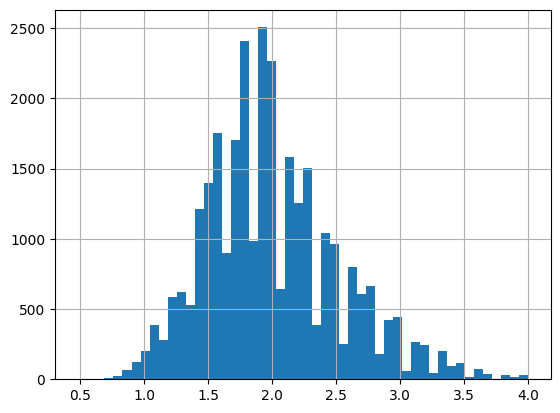

In [78]:
df[df['Structure resolution (Angstroms)'] < 20]['Structure resolution (Angstroms)'].hist(bins=50)

In [79]:
for col in df.columns:
    print(col, len(df[col].unique()))

cath_id 32388
Class number 5
Architecture number 26
Topology number 520
Homologous superfamily number 671
S35 sequence cluster number 873
S60 sequence cluster number 1
S95 sequence cluster number 1
S100 sequence cluster number 1
S100 sequence count number 1
Domain length 575
Structure resolution (Angstroms) 312


In [80]:
import numpy as np
embed_df = pd.DataFrame({"embedding_idx": np.arange(len(cath_ids)), "cath_id":cath_ids})
df = df.set_index("cath_id").join(embed_df.set_index("cath_id"), how='left', rsuffix="embed_")
df.head()

,Class number,Architecture number,Topology number,Homologous superfamily number,S35 sequence cluster number,S60 sequence cluster number,S95 sequence cluster number,S100 sequence cluster number,S100 sequence count number,Domain length,Structure resolution (Angstroms),embedding_idx
cath_id,,,,,,,,,,,,
1oaiA00,1,10,8,10,1,1,1,1,1,59,1.00,NaN
3frhA01,1,10,8,10,2,1,1,1,1,58,1.20,NaN
4g3oA00,1,10,8,10,3,1,1,1,1,53,1.60,NaN
4heoA00,1,10,8,10,4,1,1,1,1,53,1.65,NaN
1oksA00,1,10,8,10,5,1,1,1,1,51,1.80,1358.0


In [81]:
(pd.isna(df.embedding_idx).values == 0).sum()

4033

In [92]:
trimmed_df = df[~df.embedding_idx.isna()]
trimmed_df['embedding_idx'] = trimmed_df.embedding_idx.astype(int)
trimmed_df.head()

/tmp/ipykernel_24677/1140583477.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_df['embedding_idx'] = trimmed_df.embedding_idx.astype(int)


,Class number,Architecture number,Topology number,Homologous superfamily number,S35 sequence cluster number,S60 sequence cluster number,S95 sequence cluster number,S100 sequence cluster number,S100 sequence count number,Domain length,Structure resolution (Angstroms),embedding_idx
cath_id,,,,,,,,,,,,
1oksA00,1,10,8,10,5,1,1,1,1,51,1.80,1358
1xb2B01,1,10,8,10,23,1,1,1,1,60,2.20,4690
1bvsF03,1,10,8,10,37,1,1,1,1,45,3.00,712
1im2A02,1,10,8,10,38,1,1,1,1,40,2.80,1986
1g3iW02,1,10,8,10,44,1,1,1,1,18,3.41,3551


In [93]:
val, counts = np.unique(trimmed_df['Architecture number'], return_counts=True)
val

array([ 10,  15,  20,  25,  30,  40,  50,  55,  60,  65,  70,  75,  80,
        90, 100, 102, 110, 115, 120, 130, 140, 150, 160, 170])

<Axes: >

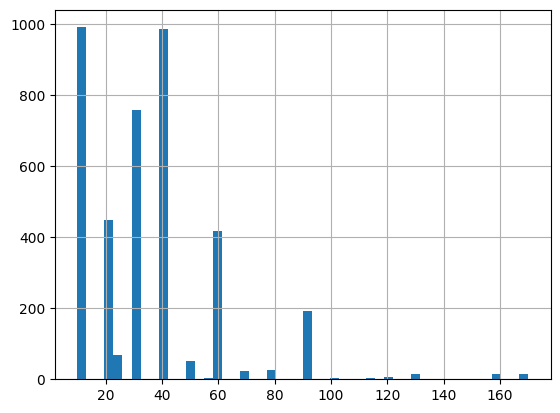

In [94]:
trimmed_df['Architecture number'].hist(bins=50)

<Axes: >

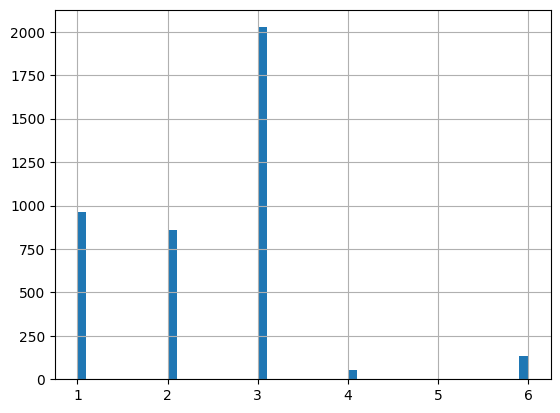

In [95]:
trimmed_df['Class number'].hist(bins=50)

<Axes: >

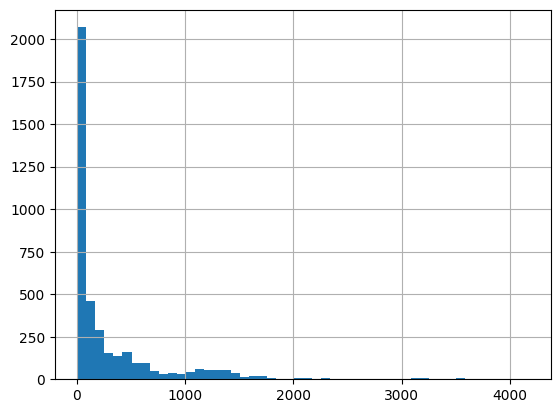

In [96]:
trimmed_df['Topology number'].hist(bins=50)

In [97]:
def fn(x):
    return x in [1,2,3]
    
even_more_trimmed_df = trimmed_df[trimmed_df['Class number'].map(fn)]
print(even_more_trimmed_df.shape)
even_more_trimmed_df.head()

(3848, 12)


,Class number,Architecture number,Topology number,Homologous superfamily number,S35 sequence cluster number,S60 sequence cluster number,S95 sequence cluster number,S100 sequence cluster number,S100 sequence count number,Domain length,Structure resolution (Angstroms),embedding_idx
cath_id,,,,,,,,,,,,
1oksA00,1,10,8,10,5,1,1,1,1,51,1.80,1358
1xb2B01,1,10,8,10,23,1,1,1,1,60,2.20,4690
1bvsF03,1,10,8,10,37,1,1,1,1,45,3.00,712
1im2A02,1,10,8,10,38,1,1,1,1,40,2.80,1986
1g3iW02,1,10,8,10,44,1,1,1,1,18,3.41,3551


In [137]:
for col in even_more_trimmed_df.columns:
    print(col, len(even_more_trimmed_df[col].unique()))

Class number 3
Architecture number 24
Topology number 294
Homologous superfamily number 333
S35 sequence cluster number 471
S60 sequence cluster number 1
S95 sequence cluster number 1
S100 sequence cluster number 1
S100 sequence count number 1
Domain length 410
Structure resolution (Angstroms) 235
embedding_idx 3848


In [103]:
%%time

embed_dict = {
    "original": xs.numpy()
}

from sklearn.manifold import TSNE
import time

start = time.time()
tsne = TSNE()
tsne_embed = tsne.fit_transform(embed_dict['original'].mean(axis=1))
end = time.time()

CPU times: user 53.8 s, sys: 25.2 ms, total: 53.8 s
Wall time: 54.2 s


In [114]:
idx_order = even_more_trimmed_df.embedding_idx.values
print(idx_order)
print("original")
print(tsne_embed)

tsne_embed_reordered = tsne_embed[idx_order]
print("reordered")
print(tsne_embed_reordered)

[1358 4690  712 ... 6176 1801 3866]
original
[[ 38.10725     0.6009491]
 [ -4.4261255  54.86049  ]
 [ 42.767548  -30.513386 ]
 ...
 [ 33.766937  -53.55582  ]
 [ 27.685326    3.3791885]
 [-62.88117   -24.304148 ]]
reordered
[[-63.228855  17.964306]
 [-41.562817  44.703503]
 [-59.936054  10.144366]
 ...
 [-77.92575    5.782893]
 [-46.207222 -50.4105  ]
 [-15.813048  46.966194]]


In [115]:
TSNE_EMBED_DICTS = {}
TSNE_EMBED_DICTS['original'] = even_more_trimmed_df.copy()
TSNE_EMBED_DICTS['original']['tsne1'] = tsne_embed_reordered[:, 0]
TSNE_EMBED_DICTS['original']['tsne2'] = tsne_embed_reordered[:, 1]

In [136]:
import pickle as pkl
with open(f"tsne_pickles/original_54-32secs.pkl", "wb") as f:
    pkl.dump(TSNE_EMBED_DICTS['original'], f)

<Axes: xlabel='tsne1', ylabel='tsne2'>

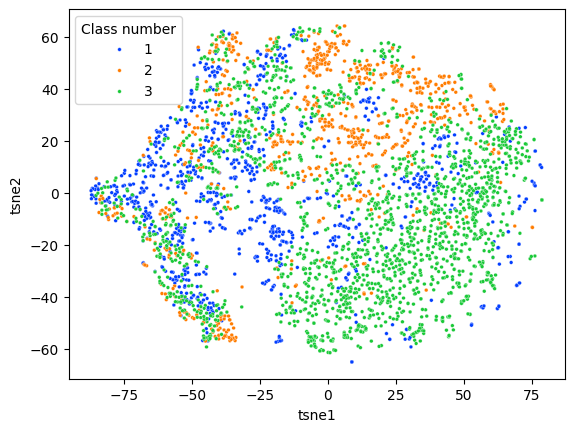

In [126]:
sns.scatterplot(data=TSNE_EMBED_DICTS['original'], x='tsne1', y='tsne2', hue='Class number',s=7, palette="bright")

<Axes: xlabel='tsne1', ylabel='tsne2'>

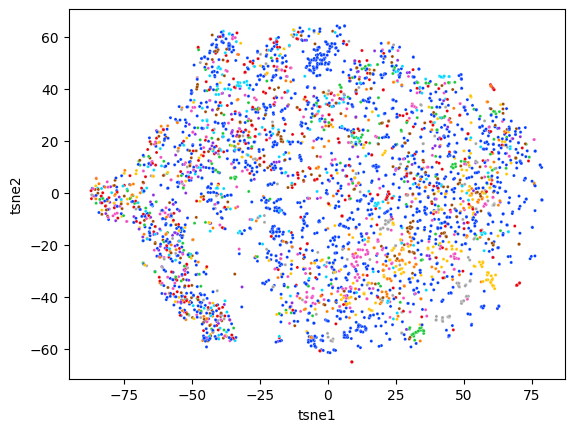

In [129]:
sns.scatterplot(data=TSNE_EMBED_DICTS['original'], x='tsne1', y='tsne2', hue='Homologous superfamily number',s=5, palette="bright",legend=False)

<Axes: xlabel='tsne1', ylabel='tsne2'>

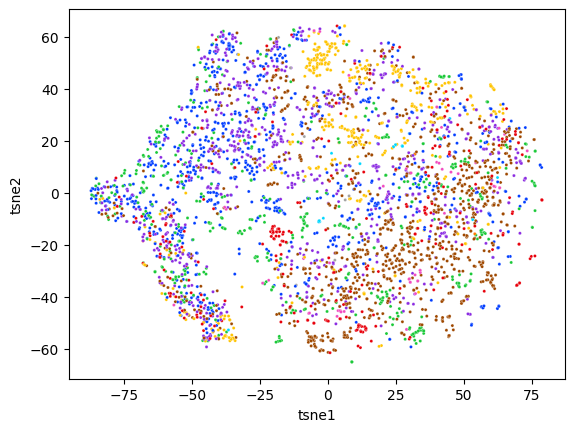

In [130]:
sns.scatterplot(data=TSNE_EMBED_DICTS['original'], x='tsne1', y='tsne2', hue='Architecture number',s=5, palette="bright",legend=False)

<Axes: xlabel='tsne1', ylabel='tsne2'>

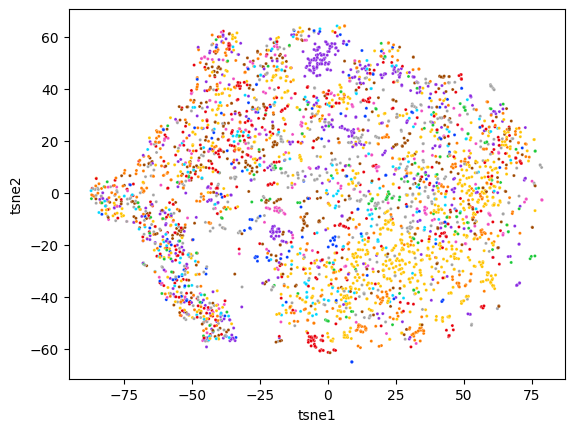

In [131]:
sns.scatterplot(data=TSNE_EMBED_DICTS['original'], x='tsne1', y='tsne2', hue='Topology number',s=5, palette="bright",legend=False)

In [134]:
seqs = np.array(sequences)[idx_order]

print(sequences[:3])
print("----")
print(seqs[:3])

['LKRLQGQKAWTAARAAFRRSLAFPPGAYPRAPYVEPFLAKGDWRQEEREAHYLVAALYALKDGDHQVGRTLARALWEKAQGSASVEKRFLALLEADRDQIAFRLRQAVALVEGGIDFARLLDDLLRWF', 'PEPGKKPVSAFSKKPRSVEVAAGSPAVFEAETERAGVKVRWQRGGSDISASNKYGLATEGTRHTLTVREVGPADQGSYAVIAGSSKVKFDLKVIE', 'KAKFGEDLVENEQFVVHDSRNSENMELIGTLPSGGKLEINKLAVEADLLVAEGFIEPHFFAGFSGGRKSILPGIASVQCILANHCSEFIKNPYARTGVLENNPIHRDMIYAAKKANLAFILNVVIDSS']
----
['ASRSVIRSIIKSSRLEEDRKRYLTLLDDIKGANDLAKFHQLVKIIKHHHHH'
 'SASSKELLMKLRRKTGYSFINCKKALETCGGDLKQAESWLHKQAQKEGWSKAARLHGRKT'
 'NAVRGSVVEALVGLGFAAKQAEEATDQVLDGEATSSALRAALSLL']
